# **Abandono de carrera por estudiantes mediante implementación de clasificación con Feed-Forward en PyTorch**

Asignatura: INF395 - Introducción a las Redes Neuronales y Deep Learning.

Integrantes:
* Bruno Morici - ROL: 202373555-8
* Juan Pablo Fuenzalida - ROL: 202373102-1
* Tutor: Alejandro Veloz


Usando el dataset de la UCL Machine Learning "Students' Dropout and Academic Success Dataset". Acceder mediante el siguiente link : https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

## Importación e instalación de librerias necesarias

In [71]:
%pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
%pip install torch
%pip install tqdm
%pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from scipy.stats import zscore
from ucimlrepo import fetch_ucirepo
from tqdm import tqdm

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo utilizado: {device}') 

Dispositivo utilizado: cpu


## Limpieza y carga del Dataset

In [73]:
# Cargar el dataset (por ID)
dataset = fetch_ucirepo(id=697)

# Acceder a los datos como DataFrame de pandas
df = dataset.data.features
target = dataset.data.targets

# Unimos features con targets en un solo DataFrame
df = pd.concat([df, target], axis=1)

# Mostrar las primeras filas
df.head()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


**Información del dataset:**

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital Status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

**Revisando si existen valores nulos en el dataset:**

In [75]:
df.isna().sum()

Marital Status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

**Convertimos los nombres de las columnas a minúsculas para facilitar su manejo:**

In [76]:
df.columns = [col.replace(' ','_').replace("'s",'').replace('\t','').replace('/','_').replace('(','').replace(')','').lower() for col in df.columns]
df.columns

Index(['marital_status', 'application_mode', 'application_order', 'course',
       'daytime_evening_attendance', 'previous_qualification',
       'previous_qualification_grade', 'nacionality', 'mother_qualification',
       'father_qualification', 'mother_occupation', 'father_occupation',
       'admission_grade', 'displaced', 'educational_special_needs', 'debtor',
       'tuition_fees_up_to_date', 'gender', 'scholarship_holder',
       'age_at_enrollment', 'international',
       'curricular_units_1st_sem_credited',
       'curricular_units_1st_sem_enrolled',
       'curricular_units_1st_sem_evaluations',
       'curricular_units_1st_sem_approved', 'curricular_units_1st_sem_grade',
       'curricular_units_1st_sem_without_evaluations',
       'curricular_units_2nd_sem_credited',
       'curricular_units_2nd_sem_enrolled',
       'curricular_units_2nd_sem_evaluations',
       'curricular_units_2nd_sem_approved', 'curricular_units_2nd_sem_grade',
       'curricular_units_2nd_sem_without

Explicación para cada columna de la tabla:

| Columna                                        | Significado                                                                                                                 |
| ---------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------- |
| `marital_status`                               | Estado civil del alumno/a al momento de la inscripción.                                                                     |
| `application_mode`                             | Modo de aplicación al curso (por ejemplo, presencial vs. en línea, u otra categoría).                                       |
| `application_order`                            | Orden de la solicitud de ingreso (por ejemplo, cuántas aplicaciones realizó antes, o prioridad de la solicitud).            |
| `course`                                       | Código o identificador del curso al que se inscribió el estudiante.                                                         |
| `daytime_evening_attendance`                   | Asistencia: diurna o vespertina (día vs. noche) para el curso.                                                              |
| `previous_qualification`                       | Tipo de cualificación/título anterior que tenía el estudiante antes de este nivel educativo.                                |
| `previous_qualification_grade`                 | Nota o calificación obtenida en la cualificación anterior.                                                                  |
| `nacionality`                                  | Nacionalidad del estudiante.                                                                                                |
| `mother_qualification`                         | Nivel de formación de la madre del estudiante.                                                                              |
| `father_qualification`                         | Nivel de formación del padre del estudiante.                                                                                |
| `mother_occupation`                            | Ocupación laboral de la madre del estudiante.                                                                               |
| `father_occupation`                            | Ocupación laboral del padre del estudiante.                                                                                 |
| `admission_grade`                              | Nota de admisión al curso/universidad del estudiante.                                                                       |
| `displaced`                                    | Si el estudiante es desplazado (por ejemplo, geográfica o socialmente) o no.                                                |
| `educational_special_needs`                    | Si el estudiante tiene necesidades educativas especiales.                                                                   |
| `debtor`                                       | Si el estudiante adeuda pagos (por ejemplo, matrícula u otros cargos) o no.                                                 |
| `tuition_fees_up_to_date`                      | Si las tasas de matrícula están al día o no.                                                                                |
| `gender`                                       | Género del estudiante.                                                                                                      |
| `scholarship_holder`                           | Si el estudiante tiene una beca o no.                                                                                       |
| `age_at_enrollment`                            | Edad del estudiante al momento de la inscripción.                                                                           |
| `international`                                | Si el estudiante es internacional (extranjero) o no.                                                                        |
| `curricular_units_1st_sem_credited`            | Unidades curriculares acreditadas en el primer semestre.                                                                    |
| `curricular_units_1st_sem_enrolled`            | Unidades curriculares en que se matriculó el estudiante en el primer semestre.                                              |
| `curricular_units_1st_sem_evaluations`         | Número de unidades curriculares que fueron evaluadas en el primer semestre.                                                 |
| `curricular_units_1st_sem_approved`            | Unidades curriculares aprobadas en el primer semestre.                                                                      |
| `curricular_units_1st_sem_grade`               | Nota promedio o de alguna unidad en el primer semestre (o quizá nota global del semestre).                                  |
| `curricular_units_1st_sem_without_evaluations` | Unidades curriculares del primer semestre sin evaluación (por ejemplo exentas u otro motivo).                               |
| `curricular_units_2nd_sem_credited`            | Unidades curriculares acreditadas en el segundo semestre.                                                                   |
| `curricular_units_2nd_sem_enrolled`            | Unidades curriculares en que se matriculó el estudiante en el segundo semestre.                                             |
| `curricular_units_2nd_sem_evaluations`         | Número de unidades curriculares que fueron evaluadas en el segundo semestre.                                                |
| `curricular_units_2nd_sem_approved`            | Unidades curriculares aprobadas en el segundo semestre.                                                                     |
| `curricular_units_2nd_sem_grade`               | Nota promedio o de alguna unidad en el segundo semestre (o nota global).                                                    |
| `curricular_units_2nd_sem_without_evaluations` | Unidades curriculares del segundo semestre sin evaluación.                                                                  |
| `unemployment_rate`                            | Tasa de desempleo correspondiente al contexto económico del estudiante (o región) en el momento.                            |
| `inflation_rate`                               | Tasa de inflación correspondiente al contexto económico del estudiante (o región) en el momento.                            |
| `gdp`                                          | Producto interno bruto (PIB) correspondiente al contexto económico del estudiante (o región) en el momento.                 |
| `target`                                       | Si el estudiante abandonó, se graduó o sigue cursando en la actualidad. |


**Análisis Exploratorio de datos**

In [77]:
df.describe()

,marital_status,application_mode,application_order,course,daytime_evening_attendance,previous_qualification,previous_qualification_grade,nacionality,mother_qualification,father_qualification,...,curricular_units_1st_sem_without_evaluations,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


**Eliminamos Outliers con el método de Z-Score**

In [78]:
threshold = 3

z_scores = zscore(df.select_dtypes(include=[np.number]))
outliers = (np.abs(z_scores) > threshold).any(axis=1)
df_2 = df[~outliers].copy()

print(f"Se eliminaron { len(df) - len(df_2) } filas del dataset")
df_2

Se eliminaron 1343 filas del dataset


,marital_status,application_mode,application_order,course,daytime_evening_attendance,previous_qualification,previous_qualification_grade,nacionality,mother_qualification,father_qualification,...,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,target
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
6,1,1,1,9500,1,1,142.0,1,19,38,...,0,8,8,8,14.345000,0,15.5,2.8,-4.06,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4410,1,1,1,9070,1,1,124.0,1,37,19,...,1,6,9,5,12.500000,0,10.8,1.4,1.74,Graduate
4412,1,43,1,9070,1,1,125.0,1,19,19,...,2,6,7,5,12.200000,0,13.9,-0.3,0.79,Enrolled
4414,1,1,1,9130,1,1,137.0,1,3,38,...,0,5,8,5,11.600000,0,9.4,-0.8,-3.12,Graduate
4417,1,1,1,9070,1,1,132.0,1,1,1,...,0,6,6,6,13.500000,0,16.2,0.3,-0.92,Graduate


**Verificamos que no haya desbalanceo de clases**

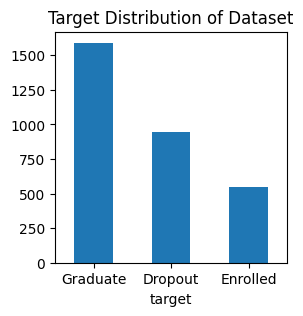

In [79]:
df_2['target'].value_counts()
df_2["target"].value_counts().plot(kind="bar", figsize=(3,3), title="Target Distribution of Dataset")
plt.xticks(rotation=0)
plt.show()

Como existe desbalanceo de clases, usaremos el método de **Balanceo Artificial por vía de Modificación de Función Objetivo** para las muestras que sean de las clases "Dropout" y "Enrolled"

## Separación del dataset en entrenamiento y testing

**Eliminamos la columna de Enrolled, ya que no aporta información relevante para el análisis**

In [80]:
df_2 = df_2.drop(df_2[df_2['target'] == 'Enrolled'].index)

# Verificamos que se eliminó
print(df_2['target'].unique())

['Graduate' 'Dropout']


Le asignamos un número a cada clase para que PyTorch pueda trabajar con ellas:

In [81]:
class_names, y = np.unique(df_2['target'], return_inverse=True)
print(y)
print(class_names)
X = df_2.drop('target', axis=1)

[1 0 1 ... 1 1 0]
['Dropout' 'Graduate']


**Visualización de la distribución de la variable objetivo 'target' sin 'Enrolled'**

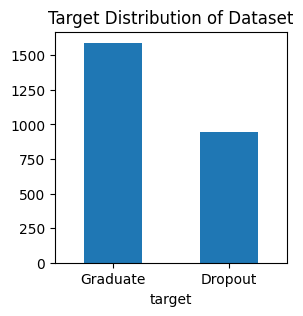

In [82]:
df_2['target'].value_counts()
df_2["target"].value_counts().plot(kind="bar", figsize=(3,3), title="Target Distribution of Dataset")
plt.xticks(rotation=0)
plt.show()

**One Hot Encoding**

In [83]:
one_hot_cols = ['marital_status',
                'daytime_evening_attendance',
                'tuition_fees_up_to_date',
                'educational_special_needs',
                'displaced',
                'scholarship_holder',
                'gender',
                'debtor',
                'international',
                ]

for i in one_hot_cols:
    X[i] = X[i].apply(lambda x: float(x))
    X[i] = X[i].apply(lambda x: int(x))

for i in one_hot_cols:
    dum = pd.get_dummies(X[i], prefix=i)
    X.drop([i], axis=1, inplace=True)
    X = pd.concat([X, dum], axis=1)

**Dividimos el Dataset en entrenamiento y testing**

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train_corr = X_train.copy()
X_train_corr['target'] = y_train

**Mapa de correlación de la variable target en base a las diferentes columnas de el Dataset**

Text(0.5, 1.0, 'Features Correlation with target')

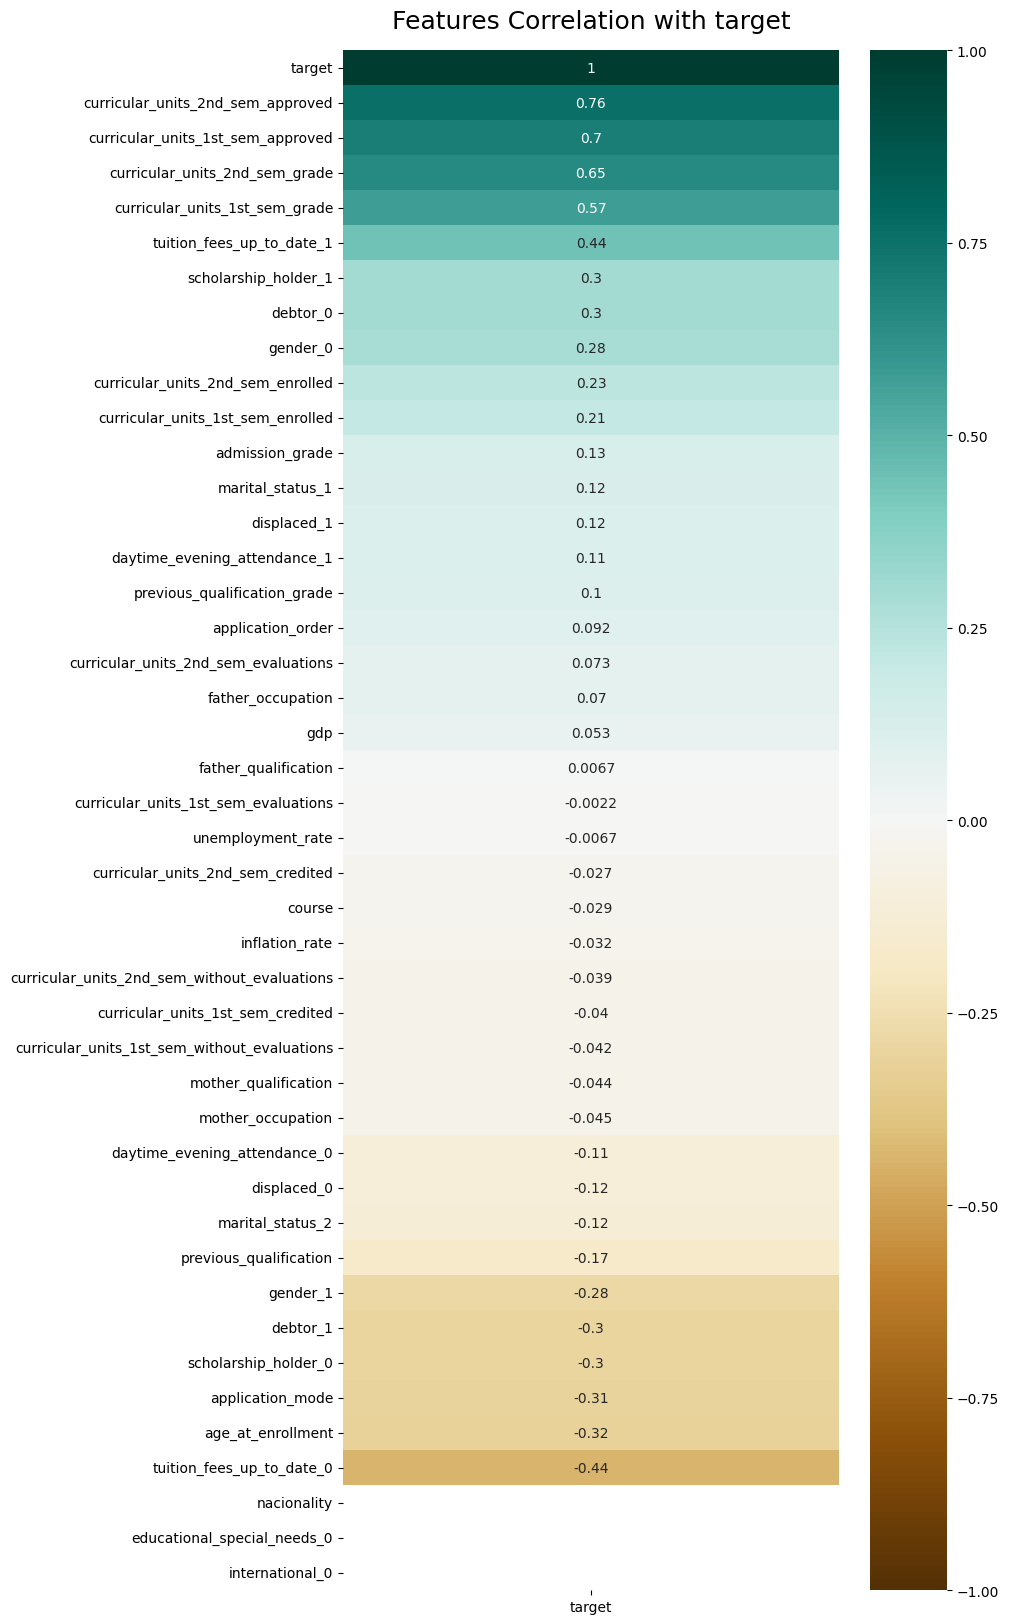

In [85]:
plt.figure(figsize=(8, 20))
heatmap = sns.heatmap(X_train_corr.corr()[['target']].sort_values(by='target', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlation with target', fontdict={'fontsize':18}, pad=16)

**Seleccionamos las features que deseamos analizar.**

In [86]:
features_list = ['curricular_units_2nd_sem_approved',
                 'curricular_units_1st_sem_approved',
                 'curricular_units_2nd_sem_grade',
                 'curricular_units_1st_sem_grade',
                 'tuition_fees_up_to_date_1',
                 'scholarship_holder_1',
                 'debtor_0',
                 'gender_0',
                 'curricular_units_2nd_sem_enrolled',
                 'curricular_units_1st_sem_enrolled',
                 'tuition_fees_up_to_date_0',
                 'age_at_enrollment',
                 'application_mode',
                 'scholarship_holder_0',
                 'debtor_1',
                 'gender_1']

**Recortamos el entrenamiento y testing a esas features**

In [87]:
X_train_fs = X_train[features_list]
X_test_fs = X_test[features_list]

**Normalizamos de forma estándar los datos, con el fin de no darle más relevancia al número por su tamaño en sí, si no que por su impacto respecto a los otros datos**

In [88]:
scaler = StandardScaler()
scaler.fit(X_train_fs)

X_train_sc = scaler.transform(X_train_fs)
X_test_sc = scaler.transform(X_test_fs)
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_fs.columns)
X_test_sc = pd.DataFrame(X_test_sc, columns=X_test_fs.columns)

**Aplicamos PCA para disminuir la complejidad del modelo**

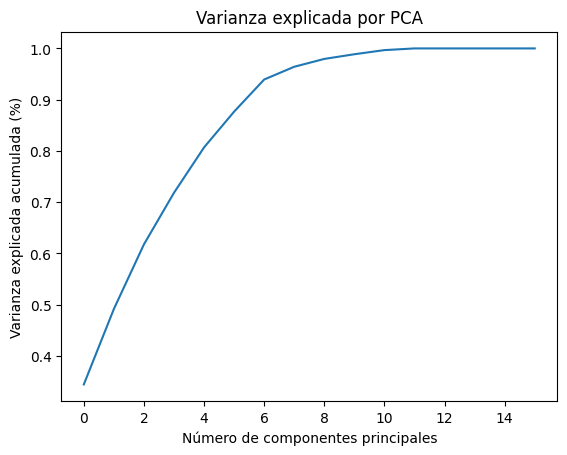

In [89]:
# Ajustar el modelo PCA a los datos de entrenamiento ya escalados
pca = PCA().fit(X_train_sc)

# Crear una figura y graficar la varianza acumulada explicada por los componentes principales
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada (%)')
plt.title('Varianza explicada por PCA')
plt.show()

In [90]:
num_pca = 16
pca = PCA(n_components=num_pca, whiten=True).fit(X_train_sc)
X_train_pc = pca.transform(X_train_sc)
X_test_pc = pca.transform(X_test_sc)

**Balanceamos mediante modificación de la Función Objetivo, haciendo variar los pesos**

In [91]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{np.int64(0): np.float64(1.3448275862068966),
 np.int64(1): np.float64(0.7959183673469388)}

## Modelo de predicción

**Configuración de Hiperparámetros**

Definimos los hiperparámetros que definirán la creación y modelamiento de nuestro modelo de predicción, siendo estas:

1. input_size que define el tamaño de la primera capa de la red neuronal.

2. num_layers especifica el número de capas ocultas en la arquitectura de la red neuronal.

3. hidden_sizes define el número de neuronas de cada capa oculta del modelo.

4. dropout_rates especifica la tasa de dropout para cada capa oculta, siendo esta una técnica de regularización que desactiva aleatoriamente un porcentaje de neuronas durante el entrenamiento para prevenir el sobreajuste.

5. activation define la función de activación utilizada en las capas ocultas.

6. learning_rate controla el tamaño de los pasos que toma el optimizador durante el entrenamiento.

7. batch_size define el número de muestras que se procesan antes de actualizar los pesos del modelo.

8. num_epochs especifica el número máximo de iteraciones completas sobre todo el conjunto de entrenamiento.

9. weight_decay implementa regularización L2, que penaliza los pesos grandes del modelo, previniendo el sobreajuste.

10. patience define el número de épocas que el modelo puede entrenar sin mejorar antes de activar el early stopping.


In [92]:
HYPERPARAMETERS = {
    'input_size': 16, 
    'num_layers': 4, 
    'hidden_sizes': [128, 64, 32, 16], 
    'dropout_rates': [0.4, 0.3, 0.2, 0.1],  
    'activation': 'relu', 
    'learning_rate': 0.0005, 
    'batch_size': 32,  
    'num_epochs': 200,  
    'weight_decay': 0.0005, 
    'patience': 25, 
}

**Resumen del Modelo**

Nuestro modelo de prediccion es una red neuronal feedforward diseñada para clasificar estudiantes en tres categorías: Dropout, Enrolled y Graduate. 

Utiliza dropout progresivo para regularización efectiva, ademas implementa función de activación ReLU para introducir no-linealidad. Aplica Softmax en la salida para generar probabilidades de pertenencia a cada clase, para finalmente producir una distribución de probabilidades sobre las tres clases posibles.


In [93]:
class StudentDropoutModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rates, activation='relu', num_classes=2):
        super(StudentDropoutModel, self).__init__()
        
        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            self.activation = nn.ReLU()
        
        prev_size = input_size
        for hidden_size, dropout_rate in zip(hidden_sizes, dropout_rates):
            self.layers.append(nn.Linear(prev_size, hidden_size))
            self.dropouts.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        self.output = nn.Linear(prev_size, num_classes)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        for layer, dropout in zip(self.layers, self.dropouts):
            x = layer(x)
            x = self.activation(x)
            x = dropout(x)
        
        x = self.output(x)
        return self.softmax(x)
    
    def predict_class(self, x):
        with torch.no_grad():
            probs = self.forward(x)
            return torch.argmax(probs, dim=1)

model = StudentDropoutModel(
    input_size=HYPERPARAMETERS['input_size'],
    hidden_sizes=HYPERPARAMETERS['hidden_sizes'],
    dropout_rates=HYPERPARAMETERS['dropout_rates'],
    activation=HYPERPARAMETERS['activation'],
    num_classes=2
).to(device)

print(f"\nArquitectura del modelo:")
print(model)
print(f"\nNúmero total de parámetros: {sum(p.numel() for p in model.parameters()):,}")


Arquitectura del modelo:
StudentDropoutModel(
  (layers): ModuleList(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=16, bias=True)
  )
  (dropouts): ModuleList(
    (0): Dropout(p=0.4, inplace=False)
    (1): Dropout(p=0.3, inplace=False)
    (2): Dropout(p=0.2, inplace=False)
    (3): Dropout(p=0.1, inplace=False)
  )
  (activation): ReLU()
  (output): Linear(in_features=16, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

Número total de parámetros: 13,074


**Dataset y DataLoader para PyTorch**

Preparamos los datasets apropiados para el modelo para el set de entrenamiento y testeo, y sus respectivo dataloaders.

In [94]:
# Clase Dataset personalizada
class StudentDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Crear datasets
train_dataset = StudentDataset(X_train_pc, y_train)
test_dataset = StudentDataset(X_test_pc, y_test)

# Crear DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=HYPERPARAMETERS['batch_size'], 
    shuffle=True
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=HYPERPARAMETERS['batch_size'], 
    shuffle=False
)

print(f"Tamaño del conjunto de entrenamiento: {len(train_dataset)}")
print(f"Tamaño del conjunto de prueba: {len(test_dataset)}")

Tamaño del conjunto de entrenamiento: 2028
Tamaño del conjunto de prueba: 507


**Entrenamiento del modelo**

El proceso de entrenamiento del modelo implementa balanceo de clases, utilizando pesos de clases calculados para manejar el desbalance en el dataset, la función de pérdida CrossEntropyLoss con pesos de clases para penalizar más los errores en clases desbalanceadas. Utilizamos el optimizador Adam para prevenir sobreajuste y un Learning Rate Scheduler ReduceLROnPlateau que reduce el learning rate automáticamente cuando la pérdida de validación deja de mejorar, finalmente el Early Stopping, que detiene el entrenamiento si no hay mejora en la pérdida de validación por 25 épocas consecutivas, restaurando automáticamente el mejor modelo encontrado.

Podemos describir el proceso de entrenamiento en tres fases:
1. Fase de entrenamiento: 
   - El modelo procesa batches de datos de entrenamiento
   - Calcula la pérdida mediante forward pass
   - Actualiza los pesos mediante backward pass y optimizador
   - Calcula precisión y pérdida promedio

2. Fase de validación:
   - Evalúa el modelo en el conjunto de validación sin actualizar pesos
   - Calcula métricas de validación
   - Actualiza el learning rate scheduler basado en la pérdida de validación

3. Monitoreo y control:
   - Guarda el mejor modelo basado en la pérdida de validación
   - Implementa early stopping para prevenir sobreajuste
   - Muestra métricas en tiempo real mediante barras de progreso

In [95]:
class_weights_tensor = torch.FloatTensor([class_weights[i] for i in sorted(class_weights.keys())]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = optim.Adam(
    model.parameters(), 
    lr=HYPERPARAMETERS['learning_rate'],
    weight_decay=HYPERPARAMETERS['weight_decay']
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_loss = float('inf')
best_val_acc = 0.0
patience_counter = 0
best_model_state = None
best_epoch = 0

print("Iniciando entrenamiento...\n")
epoch_pbar = tqdm(range(HYPERPARAMETERS['num_epochs']), desc='Entrenamiento', unit='epoch')

for epoch in epoch_pbar:
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{HYPERPARAMETERS["num_epochs"]} [Train]', leave=False, unit='batch')
    for features, labels in train_pbar:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        train_acc_batch = 100 * train_correct / train_total
        train_pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{train_acc_batch:.2f}%'
        })
    
    train_loss /= len(train_loader)
    train_acc = 100 * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    val_pbar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{HYPERPARAMETERS["num_epochs"]} [Val]', 
                    leave=False, unit='batch')
    
    with torch.no_grad():
        for features, labels in val_pbar:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            val_acc_batch = 100 * val_correct / val_total
            val_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{val_acc_batch:.2f}%'
            })
    
    val_loss /= len(test_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    epoch_pbar.set_postfix({
        'Train Loss': f'{train_loss:.4f}',
        'Train Acc': f'{train_acc:.2f}%',
        'Val Loss': f'{val_loss:.4f}',
        'Val Acc': f'{val_acc:.2f}%',
        'Best Val Acc': f'{best_val_acc:.2f}%',
        'Patience': f'{patience_counter}/{HYPERPARAMETERS["patience"]}'
    })
    
    if val_loss < best_val_loss:
        improvement = best_val_loss - val_loss
        best_val_loss = val_loss
        best_val_acc = val_acc
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        best_epoch = epoch + 1
        epoch_pbar.write(f'✓ Mejora en epoch {epoch+1}: Val Loss mejoró de {best_val_loss + improvement:.4f} a {best_val_loss:.4f} (Val Acc: {val_acc:.2f}%)')
    else:
        patience_counter += 1
        if patience_counter >= HYPERPARAMETERS['patience']:
            epoch_pbar.write(f'\n⚠ Early stopping activado en epoch {epoch+1}')
            epoch_pbar.write(f'   Mejor modelo encontrado en epoch {best_epoch}')
            epoch_pbar.write(f'   Mejor Val Loss: {best_val_loss:.4f}')
            epoch_pbar.write(f'   Mejor Val Acc: {best_val_acc:.2f}%')
            epoch_pbar.write(f'   Razón: No hubo mejora en Val Loss por {HYPERPARAMETERS["patience"]} épocas consecutivas')
            epoch_pbar.write(f'   El modelo se detuvo para prevenir sobreajuste (overfitting)')
            model.load_state_dict(best_model_state)
            break

epoch_pbar.close()
print("\n" + "="*60)
print("ENTRENAMIENTO COMPLETADO")
print("="*60)
print(f"Mejor modelo guardado de epoch {best_epoch}")
print(f"Mejor Val Loss: {best_val_loss:.4f}")
print(f"Mejor Val Acc: {best_val_acc:.2f}%")
print(f"Total de épocas entrenadas: {len(train_losses)}")


Iniciando entrenamiento...



Entrenamiento:   0%|          | 1/200 [00:00<01:36,  2.06epoch/s, Train Loss=0.6806, Train Acc=71.50%, Val Loss=0.6407, Val Acc=89.15%, Best Val Acc=0.00%, Patience=0/25]

✓ Mejora en epoch 1: Val Loss mejoró de inf a 0.6407 (Val Acc: 89.15%)


Entrenamiento:   1%|          | 2/200 [00:00<01:38,  2.01epoch/s, Train Loss=0.5523, Train Acc=87.18%, Val Loss=0.4392, Val Acc=91.12%, Best Val Acc=89.15%, Patience=0/25]

✓ Mejora en epoch 2: Val Loss mejoró de 0.6407 a 0.4392 (Val Acc: 91.12%)


Entrenamiento:   2%|▏         | 3/200 [00:01<01:34,  2.09epoch/s, Train Loss=0.4377, Train Acc=89.99%, Val Loss=0.4044, Val Acc=91.52%, Best Val Acc=91.12%, Patience=0/25]

✓ Mejora en epoch 3: Val Loss mejoró de 0.4392 a 0.4044 (Val Acc: 91.52%)


Entrenamiento:   2%|▎         | 5/200 [00:02<01:34,  2.06epoch/s, Train Loss=0.4150, Train Acc=91.22%, Val Loss=0.3933, Val Acc=92.90%, Best Val Acc=91.52%, Patience=1/25]

✓ Mejora en epoch 5: Val Loss mejoró de 0.4044 a 0.3933 (Val Acc: 92.90%)


Entrenamiento:   4%|▍         | 8/200 [00:03<01:29,  2.14epoch/s, Train Loss=0.4037, Train Acc=91.91%, Val Loss=0.3898, Val Acc=92.70%, Best Val Acc=92.90%, Patience=2/25]

✓ Mejora en epoch 8: Val Loss mejoró de 0.3933 a 0.3898 (Val Acc: 92.70%)


Entrenamiento:   4%|▍         | 9/200 [00:04<01:33,  2.05epoch/s, Train Loss=0.4049, Train Acc=92.41%, Val Loss=0.3873, Val Acc=93.10%, Best Val Acc=92.70%, Patience=0/25]

✓ Mejora en epoch 9: Val Loss mejoró de 0.3898 a 0.3873 (Val Acc: 93.10%)


Entrenamiento:  12%|█▏        | 23/200 [00:10<01:26,  2.05epoch/s, Train Loss=0.3967, Train Acc=92.65%, Val Loss=0.3860, Val Acc=93.10%, Best Val Acc=93.10%, Patience=13/25]

✓ Mejora en epoch 23: Val Loss mejoró de 0.3873 a 0.3860 (Val Acc: 93.10%)


Entrenamiento:  14%|█▎        | 27/200 [00:12<01:23,  2.08epoch/s, Train Loss=0.3990, Train Acc=92.46%, Val Loss=0.3850, Val Acc=93.29%, Best Val Acc=93.10%, Patience=3/25] 

✓ Mejora en epoch 27: Val Loss mejoró de 0.3860 a 0.3850 (Val Acc: 93.29%)


Entrenamiento:  16%|█▌        | 32/200 [00:15<01:17,  2.16epoch/s, Train Loss=0.3991, Train Acc=92.55%, Val Loss=0.3848, Val Acc=93.49%, Best Val Acc=93.29%, Patience=4/25]

✓ Mejora en epoch 32: Val Loss mejoró de 0.3850 a 0.3848 (Val Acc: 93.49%)


Entrenamiento:  16%|█▋        | 33/200 [00:15<01:20,  2.06epoch/s, Train Loss=0.4009, Train Acc=92.31%, Val Loss=0.3831, Val Acc=93.49%, Best Val Acc=93.49%, Patience=0/25]

✓ Mejora en epoch 33: Val Loss mejoró de 0.3848 a 0.3831 (Val Acc: 93.49%)


Entrenamiento:  28%|██▊       | 57/200 [00:27<01:08,  2.08epoch/s, Train Loss=0.3914, Train Acc=93.39%, Val Loss=0.3854, Val Acc=93.29%, Best Val Acc=93.49%, Patience=24/25]


⚠ Early stopping activado en epoch 58
   Mejor modelo encontrado en epoch 33
   Mejor Val Loss: 0.3831
   Mejor Val Acc: 93.49%
   Razón: No hubo mejora en Val Loss por 25 épocas consecutivas
   El modelo se detuvo para prevenir sobreajuste (overfitting)

ENTRENAMIENTO COMPLETADO
Mejor modelo guardado de epoch 33
Mejor Val Loss: 0.3831
Mejor Val Acc: 93.49%
Total de épocas entrenadas: 58


**Gráfico de pérdida y precision por épocas**

Una vez entrenado el modelo generamos los siguientes graficos que describen la evolucion tanto de la pérdida, como de la precision a medida que crecen los epochs, comparandolos con el dataset de testeo/validacion.

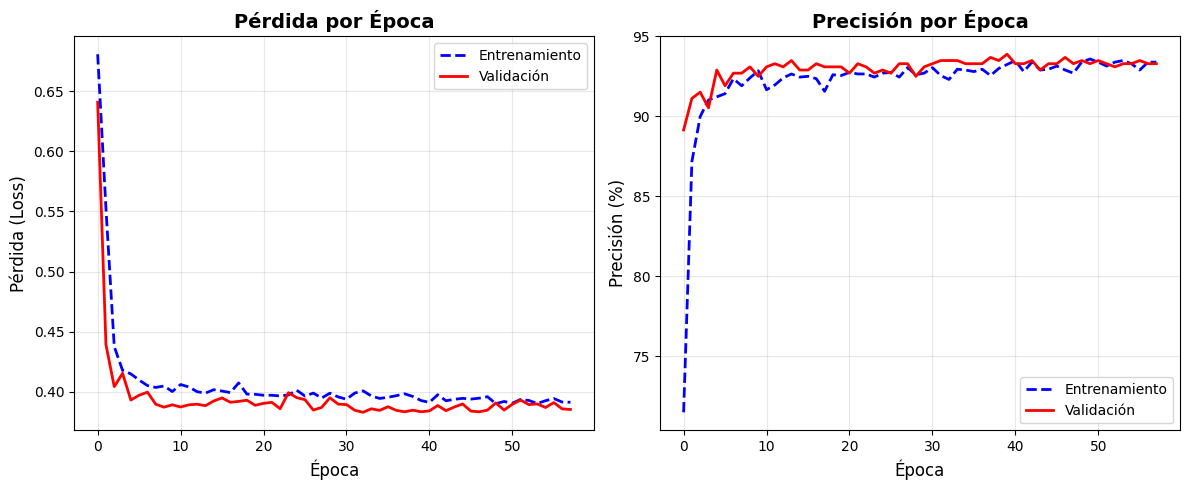

Mejor pérdida de validación: 0.3831
Mejor precisión de validación: 93.89%


In [96]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b--', label='Entrenamiento', linewidth=2)
plt.plot(val_losses, 'r-', label='Validación', linewidth=2)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Pérdida (Loss)', fontsize=12)
plt.title('Pérdida por Época', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'b--', label='Entrenamiento', linewidth=2)
plt.plot(val_accuracies, 'r-', label='Validación', linewidth=2)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Precisión (%)', fontsize=12)
plt.title('Precisión por Época', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mejor pérdida de validación: {min(val_losses):.4f}")
print(f"Mejor precisión de validación: {max(val_accuracies):.2f}%")


**Evaluación final y métricas**

Se muestran los resultados finales para los parametros del modelo, consecuencia de su entrenamiento.

In [97]:
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

y_pred = np.array(all_predictions)
y_true = np.array(all_labels)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("=" * 60)
print("RESULTADOS FINALES DEL MODELO")
print("=" * 60)
print(f"\nPrecisión (Accuracy): {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precisión (Precision - Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1-Score (Weighted): {f1:.4f}")
print("\n" + "=" * 60)
print("\nReporte de Clasificación Detallado:")
print("=" * 60)
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


RESULTADOS FINALES DEL MODELO

Precisión (Accuracy): 0.9329 (93.29%)
Precisión (Precision - Weighted): 0.9328
Recall (Weighted): 0.9329
F1-Score (Weighted): 0.9328


Reporte de Clasificación Detallado:
              precision    recall  f1-score   support

     Dropout       0.92      0.90      0.91       190
    Graduate       0.94      0.95      0.95       317

    accuracy                           0.93       507
   macro avg       0.93      0.93      0.93       507
weighted avg       0.93      0.93      0.93       507



**Matriz de Confusión**

Generamos la matriz de confusión, que permite visualizar cómo se comporta el modelo al re-clasificar cada una de las clases durante el proceso de evaluación o validación, para visualizar si efectivamente las clasifica deacuerdo a su etiqueta real.

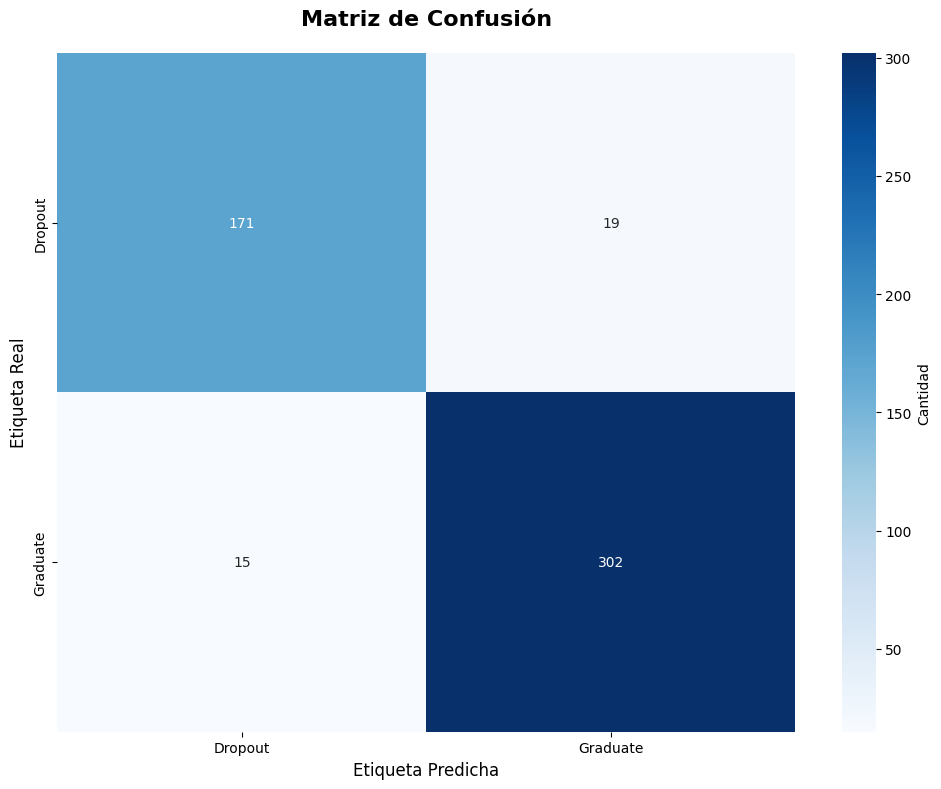


Matriz de Confusión:
               Dropout        Graduate       
Dropout                    171             19
Graduate                    15            302

Métricas por Clase:

Dropout:
  Precision: 0.9194
  Recall: 0.9000
  F1-Score: 0.9096
  Soporte: 190

Graduate:
  Precision: 0.9408
  Recall: 0.9527
  F1-Score: 0.9467
  Soporte: 317


In [98]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Cantidad'})
plt.title('Matriz de Confusión', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Etiqueta Real', fontsize=12)
plt.xlabel('Etiqueta Predicha', fontsize=12)
plt.tight_layout()
plt.show()
print("\nMatriz de Confusión:")
print("=" * 60)
print(f"{'':15}", end="")
for name in class_names:
    print(f"{name:15}", end="")
print()
for i, name in enumerate(class_names):
    print(f"{name:15}", end="")
    for j in range(len(class_names)):
        print(f"{cm[i, j]:15}", end="")
    print()
print("=" * 60)

print("\nMétricas por Clase:")
print("=" * 60)
for i, class_name in enumerate(class_names):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - tp - fp - fn
    
    precision_class = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_class = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_class = 2 * (precision_class * recall_class) / (precision_class + recall_class) if (precision_class + recall_class) > 0 else 0
    
    print(f"\n{class_name}:")
    print(f"  Precision: {precision_class:.4f}")
    print(f"  Recall: {recall_class:.4f}")
    print(f"  F1-Score: {f1_class:.4f}")
    print(f"  Soporte: {cm[i, :].sum()}")


**Ejemplo de aplicación del Modelo**


In [99]:
def predict_student(student_data, model, scaler, pca, class_names, device):
    model.eval()
    df = pd.DataFrame([student_data])
    
    missing_cols = set(X_train_fs.columns) - set(df.columns)
    for col in missing_cols:
        df[col] = 0
    
    df = df[X_train_fs.columns]
    df_scaled = scaler.transform(df)
    df_pc = pca.transform(df_scaled)

    with torch.no_grad():
        df_tensor = torch.FloatTensor(df_pc).to(device)
        probs = model(df_tensor)
        pred_class_idx = torch.argmax(probs, dim=1).item()
        probabilities = probs[0].cpu().numpy()
    
    return class_names[pred_class_idx], probabilities

student = {
    'curricular_units_2nd_sem_approved': 5,
    'curricular_units_1st_sem_approved': 6,
    'curricular_units_2nd_sem_grade': 12.5,
    'curricular_units_1st_sem_grade': 13.0,
    'tuition_fees_up_to_date_1': 1,
    'scholarship_holder_1': 0,
    'debtor_0': 1,
    'gender_0': 1,
    'curricular_units_2nd_sem_enrolled': 6,
    'curricular_units_1st_sem_enrolled': 6,
    'tuition_fees_up_to_date_0': 0,
    'age_at_enrollment': 20,
    'application_mode': 1,
    'scholarship_holder_0': 1,
    'debtor_1': 0,
    'gender_1': 0
}

resultado, probabilidades = predict_student(student, model, scaler, pca, class_names, device)
print(f"Predicción del estudiante: {resultado}")
print("\nProbabilidades por clase:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {probabilidades[i]:.4f} ({probabilidades[i]*100:.2f}%)")


Predicción del estudiante: Graduate

Probabilidades por clase:
  Dropout: 0.0001 (0.01%)
  Graduate: 0.9999 (99.99%)


c:\Users\Bruno\Desktop\INF395 - IRN\proyecto_redes_neuronales\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


## Exportación del modelo entrenado y aplicación en caso real

In [100]:
if torch.cuda.is_available():
    torch.save(model.state_dict(), "student_model.pt")
else:
    torch.save(model.cpu().state_dict(), "student_model.pt")

## Análisis de sesgo y conclusiones sobre el modelo mediante SHAP

* El modelo no se entrena directamente con las features originales, sino que con componentes principales derivados de PCA. Esto puede dificultar la interpretación directa de la importancia de las features originales.
* Tampoco se pueden extraer directamente los pesos debido a que las capas ocultas introducen no linealidades y transformaciones complejas en los datos. Sin embargo, podemos analizar la importancia de las features originales mediante técnicas como SHAP (SHapley Additive exPlanations).
* Para ello primero evaluamos el primer modelo creado con SHAP y verificamos cuales PC (componentes principales) tienen mayor impacto en las predicciones del modelo. Luego descomponemos esos PC en las features originales para entender qué variables tienen mayor influencia en las predicciones del modelo.
* Finalmente, creamos un nuevo modelo que recibe distintas features como género, deudor, edad al inscribirse, calificación de admisión, unidades curriculares aprobadas y nota promedio en el primer semestre, para analizar su impacto mediante SHAP.
* Este análisis tiene por objetivo identificar posibles sesgos en el modelo y entender mejor qué factores influyen en las predicciones de abandono o éxito académico.

**Creamos una función que realiza una evaluación de cualquier modelo de input 16 PC y genera una respuesta SHAP**

In [101]:
import shap
from typing import List

def obtener_importancias_shap(
    model: torch.nn.Module, 
    X_data: np.ndarray, 
    feature_names: List[str], 
    device: torch.device,
    background_samples: int = 100,
    target_class_index: int = 1 
) -> pd.DataFrame:
    
    # 1. Crear un modelo "Logit" SOLO con capas LINEALES (Estabilidad)
    class MinimalLogitModel(torch.nn.Module):
        def __init__(self, original_model):
            super().__init__()
            self.all_linear_layers = torch.nn.ModuleList(
                list(original_model.layers) + [original_model.output]
            )

        def forward(self, x):
            for layer in self.all_linear_layers:
                x = layer(x)
            return x

    # Inicializar el modelo Logit minimalista en modo evaluación y mover a CPU
    logit_model = MinimalLogitModel(model).eval().to('cpu')
    
    # Asegurarse de que los datos son un tensor float en CPU
    X_data_tensor = torch.FloatTensor(X_data).cpu()
    
    # 2. Definir el background y el explainer
    num_samples = len(X_data_tensor)
    background = X_data_tensor[:min(background_samples, num_samples)]
    
    print(f"Calculando SHAP para {num_samples} muestras...")
    explainer = shap.DeepExplainer(logit_model, background)
    
    # 3. Calcular los valores SHAP
    shap_values = explainer.shap_values(X_data_tensor)
    
    # 4. Obtener la importancia global (Promedio del valor absoluto)
    if isinstance(shap_values, list) and target_class_index < len(shap_values):
        shap_values_target = shap_values[target_class_index]
    else:
        shap_values_target = shap_values
        
    mean_abs_shap = np.mean(np.abs(shap_values_target), axis=0)
    
    # Asegurar que el array es 1-dimensional
    mean_abs_shap = mean_abs_shap.flatten()
    
    # Verificar y alinear las longitudes
    # N = Número esperado de features/componentes
    N = len(feature_names) 
    
    if len(mean_abs_shap) != N:
        print(f"\n--- ERROR DE ALINEACIÓN DETECTADO ---")
        print(f"Longitud de nombres de features ({N}) NO coincide con la longitud de importancias ({len(mean_abs_shap)}).")
        
        # Opción 1: Si SHAP devolvió más importancias de las esperadas, recortamos.
        # Opción 2: Si SHAP devolvió menos importancias de las esperadas, truncamos nombres.
        if len(mean_abs_shap) > N:
             print(f"Recortando las importancias SHAP calculadas a {N} elementos.")
             mean_abs_shap = mean_abs_shap[:N]
        else: # len(mean_abs_shap) < N
             print(f"Truncando la lista de nombres de features a {len(mean_abs_shap)} elementos.")
             feature_names = feature_names[:len(mean_abs_shap)]
    
    # 5. Crear DataFrame y ordenar
    importance_df = pd.DataFrame({
        'Feature/Componente': feature_names,
        'Importancia_SHAP': mean_abs_shap
    })
    
    importance_df = importance_df.sort_values(
        by='Importancia_SHAP', 
        ascending=False
    ).reset_index(drop=True)
    
    return importance_df

In [102]:
# Ejecutar el Análisis SHAP
# Definir los nombres de las "features" que entran al modelo (PC)
pc_names = [f"PC_{i+1}" for i in range(num_pca)]

# Ejecutar la función de SHAP
df_importancia_shap = obtener_importancias_shap(
    model=model, 
    X_data=X_test_pc, # Usamos los datos de prueba transformados por PCA
    feature_names=pc_names,
    device=device,
    target_class_index=1 # 'Dropout' es la clase 1, 'Graduate' es 0
)

print("\n--- Importancia de los Componentes Principales (SHAP Mean Absolute) ---")
print(df_importancia_shap.to_string(index=False))

Calculando SHAP para 507 muestras...

--- ERROR DE ALINEACIÓN DETECTADO ---
Longitud de nombres de features (16) NO coincide con la longitud de importancias (32).
Recortando las importancias SHAP calculadas a 16 elementos.

--- Importancia de los Componentes Principales (SHAP Mean Absolute) ---
Feature/Componente  Importancia_SHAP
              PC_1         22.486210
              PC_2         16.551271
              PC_9          3.221171
             PC_10          2.383028
             PC_11          2.151529
             PC_13          1.997689
              PC_7          1.931984
             PC_12          1.594802
             PC_14          1.473815
              PC_8          1.423729
              PC_5          0.706677
             PC_15          0.607189
              PC_6          0.521727
             PC_16          0.447524
              PC_3          0.057186
              PC_4          0.038377


**Los PC son combinaciones lineales de features originales, por lo que interpretar su impacto puede ser desafiante. Sin embargo, al observar las cargas de las features en cada componente principal, podemos identificar qué variables contribuyen más a la varianza explicada por cada PC.**

In [103]:
# Identificar el Componente Principal más importante del análisis SHAP
pc_mas_importante = df_importancia_shap.iloc[0]['Feature/Componente'] # PC_2
pc_segundo_mas_importante = df_importancia_shap.iloc[1]['Feature/Componente'] # PC_1

# Lista de los nombres de las features originales usadas en PCA
feature_names_original = X_train_fs.columns.tolist()

print("\n" + "="*60)
print(f"ANÁLISIS DE LA COMPOSICIÓN DEL COMPONENTE MÁS INFLUYENTE: {pc_mas_importante}")
print("="*60)

# --- FUNCIÓN DE ANÁLISIS ---
def analizar_composicion_pc(pc_nombre, pca_model, feature_names):
    """Muestra las features originales con mayor peso en un Componente Principal."""
    
    # Obtener el índice del PC (PC_1 -> 0, PC_2 -> 1, etc.)
    pc_index = int(pc_nombre.split('_')[1]) - 1
    
    # Obtener los pesos (loadings) del componente
    loadings = pca_model.components_[pc_index]
    
    # Mapear los pesos a las features originales
    loadings_df = pd.DataFrame({
        'Feature_Original': feature_names,
        'Peso_en_PC': loadings
    }).sort_values(by='Peso_en_PC', key=abs, ascending=False)
    
    return loadings_df

# --- ANÁLISIS DEL PC_2 (El más importante) ---
composicion_pc2 = analizar_composicion_pc(pc_mas_importante, pca, feature_names_original)
print(f"\nComposición de {pc_mas_importante} (Contribución de las Features Originales):")
print(composicion_pc2.head(5).to_string(index=False))

print("\n" + "-"*60)

# --- ANÁLISIS DEL PC_1 (El segundo más importante) ---
composicion_pc1 = analizar_composicion_pc(pc_segundo_mas_importante, pca, feature_names_original)
print(f"\nComposición de {pc_segundo_mas_importante}:")
print(composicion_pc1.head(5).to_string(index=False))

print("\n" + "="*60)
print("CONCLUSIÓN DE IMPORTANCIA GLOBAL:")
print(f"La probabilidad de abandono depende principalmente de una combinación de features (PC_{pc_mas_importante.split('_')[1]}) que está dominada por las cinco features listadas arriba.")


ANÁLISIS DE LA COMPOSICIÓN DEL COMPONENTE MÁS INFLUYENTE: PC_1

Composición de PC_1 (Contribución de las Features Originales):
                 Feature_Original  Peso_en_PC
curricular_units_2nd_sem_approved    0.370683
curricular_units_1st_sem_approved    0.367833
   curricular_units_2nd_sem_grade    0.334185
   curricular_units_1st_sem_grade    0.318238
        tuition_fees_up_to_date_1    0.266010

------------------------------------------------------------

Composición de PC_2:
                 Feature_Original  Peso_en_PC
                         debtor_1    0.487253
                         debtor_0   -0.487253
        tuition_fees_up_to_date_1   -0.355669
        tuition_fees_up_to_date_0    0.355669
curricular_units_1st_sem_enrolled    0.273703

CONCLUSIÓN DE IMPORTANCIA GLOBAL:
La probabilidad de abandono depende principalmente de una combinación de features (PC_1) que está dominada por las cinco features listadas arriba.


**Interpretación:**
* debtor_1 = 0.4872: Indica que ser deudor tiene un impacto positivo significativo en la predicción de abandono (Dropout).
* debtor_0 = -0.4872: Indica que no ser deudor tiene un impacto negativo significativo en la predicción de abandono (Dropout).

**Creamos un nuevo modelo que recibe distintas features para analizar su impacto mediante SHAP**

In [104]:
# Definición, Selección y Alineación de Features

# Lista de las features originales que DEBEN estar representadas
features_analizar = [
    'gender',                      
    'age_at_enrollment',           
    'debtor',                      
    'application_order',           
    'daytime_evening_attendance',  
]

# Lista de features originales DESEADAS (para completar las 16)
features_relleno = [
    'application_mode',
    'curricular_units_2nd_sem_grade', 
    'curricular_units_1st_sem_grade', 
    'curricular_units_2nd_sem_approved', 
    'curricular_units_1st_sem_approved',
    'tuition_fees_up_to_date',     
    'scholarship_holder',         
    'marital_status',             
    'mother_qualification',       
    'father_qualification',       
    'admission_grade',
]

# 1. Crear una lista de las columnas OHE/Numéricas finales disponibles en X
all_available_cols = X.columns.tolist()
features_for_new_model = []

# 2. Asegurar la inclusión de todas las columnas OHE/Numéricas relacionadas con las obligatorias
for orig_feature in features_analizar:
    # Captura todas las columnas que contienen el nombre de la feature original (ej: 'gender_0', 'gender_1')
    matching_cols = [col for col in all_available_cols if col.startswith(orig_feature)]
    features_for_new_model.extend(matching_cols)
    # Removemos las columnas usadas para no repetir
    all_available_cols = [col for col in all_available_cols if col not in matching_cols]

# 3. Agregar las columnas relacionadas con las deseadas hasta alcanzar o superar 16
# Priorizamos las columnas académicas y financieras que aún no están en la lista
for orig_feature in features_relleno:
    matching_cols = [col for col in all_available_cols if col.startswith(orig_feature)]
    features_for_new_model.extend(matching_cols)
    all_available_cols = [col for col in all_available_cols if col not in matching_cols]
    
# 4. Eliminar duplicados y redefinir la lista de features a usar
features_for_new_model = list(set(features_for_new_model))

# 5. Si la lista final es mayor a 16, la ajustamos (PCA reducirá a 16 después del escalado)
# Es más robusto usar todas las features que tenemos y dejar que PCA reduzca.
# Ya que PCA espera 16 componentes, debemos asegurarnos que la entrada sea la misma
X_new_fs = X[features_for_new_model].copy()
y_new = y

# Ahora sí, dividimos y usamos la lista completa de features para PCA
features_list_new = X_new_fs.columns.tolist()

print(f"Número de features seleccionadas para el nuevo modelo (antes de PCA): {len(features_list_new)}")
print("Lista de features (ejemplo de las primeras 10):")
print(features_list_new[:10])

# Dividir
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new_fs, y_new, test_size=0.2, random_state=1)

Número de features seleccionadas para el nuevo modelo (antes de PCA): 22
Lista de features (ejemplo de las primeras 10):
['daytime_evening_attendance_1', 'gender_0', 'curricular_units_2nd_sem_grade', 'daytime_evening_attendance_0', 'curricular_units_2nd_sem_approved', 'marital_status_1', 'tuition_fees_up_to_date_0', 'marital_status_2', 'age_at_enrollment', 'debtor_0']


In [105]:
# Escalado
scaler_new = StandardScaler()
scaler_new.fit(X_train_new)

X_train_sc_new = scaler_new.transform(X_train_new)
X_test_sc_new = scaler_new.transform(X_test_new)
X_train_sc_new = pd.DataFrame(X_train_sc_new, columns=features_list_new)
X_test_sc_new = pd.DataFrame(X_test_sc_new, columns=features_list_new)

# 2. PCA, aseguramos 16 componentes
num_pca_new = 16
pca_new = PCA(n_components=num_pca_new, whiten=True).fit(X_train_sc_new)
X_train_pc_new = pca_new.transform(X_train_sc_new)
X_test_pc_new = pca_new.transform(X_test_sc_new)

# Preparación de DataLoaders
class DropoutDataset(Dataset):
    def __init__(self, features, labels):
        # Convertir a tensores
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Datasets
train_dataset_new = DropoutDataset(X_train_pc_new, y_train_new)
test_dataset_new = DropoutDataset(X_test_pc_new, y_test_new)

# DataLoaders
train_loader_new = DataLoader(
    train_dataset_new, 
    batch_size=HYPERPARAMETERS['batch_size'], 
    shuffle=True
)
test_loader_new = DataLoader(
    test_dataset_new, 
    batch_size=HYPERPARAMETERS['batch_size'], 
    shuffle=False
)

# Pesos de clase (recalculamos por si la división afectó)
classes_new = np.unique(y_train_new)
weights_new = compute_class_weight(class_weight='balanced', classes=classes_new, y=y_train_new)
class_weights_new = torch.tensor(weights_new, dtype=torch.float).to(device)

print(f"Dimensiones de entrada para el modelo (después de PCA): {X_train_pc_new.shape[1]}")
print(f"Pesos de clase para la función de pérdida: {class_weights_new}")

Dimensiones de entrada para el modelo (después de PCA): 16
Pesos de clase para la función de pérdida: tensor([1.3448, 0.7959])


**Reentrenamos el modelo**

In [106]:
# Instanciar un nuevo modelo
model_new = StudentDropoutModel(
    input_size=num_pca_new, # Debe ser 16
    hidden_sizes=HYPERPARAMETERS['hidden_sizes'],
    dropout_rates=HYPERPARAMETERS['dropout_rates'],
    activation=HYPERPARAMETERS['activation'],
    num_classes=2
).to(device)

# Definir optimizador y pérdida
optimizer_new = optim.Adam(
    model_new.parameters(), 
    lr=HYPERPARAMETERS['learning_rate'], 
    weight_decay=HYPERPARAMETERS['weight_decay']
)
criterion_new = nn.CrossEntropyLoss(weight=class_weights_new) # Usamos los nuevos pesos

# Entrenamiento simplificado
print("Iniciando reentrenamiento del modelo con las nuevas features...")
best_loss = float('inf')
patience_counter = 0
train_losses = []

for epoch in tqdm(range(HYPERPARAMETERS['num_epochs'])):
    model_new.train()
    current_loss = 0
    for features, labels in train_loader_new:
        features, labels = features.to(device), labels.to(device)
        
        optimizer_new.zero_grad()
        outputs = model_new(features)
        loss = criterion_new(outputs, labels)
        loss.backward()
        optimizer_new.step()
        
        current_loss += loss.item() * features.size(0)
    
    epoch_loss = current_loss / len(train_dataset_new)
    train_losses.append(epoch_loss)

    # Early Stopping (Simplificado)
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0
        # torch.save(model_new.state_dict(), 'best_model_new.pth') # Opcional: guardar
    else:
        patience_counter += 1
        if patience_counter >= HYPERPARAMETERS['patience']:
            # print(f"Early stopping en época {epoch}")
            break

print("Reentrenamiento finalizado.")

Iniciando reentrenamiento del modelo con las nuevas features...


 83%|████████▎ | 166/200 [00:32<00:06,  5.11it/s]

Reentrenamiento finalizado.


In [107]:
# Evaluación de Métricas

model_new.eval()
all_predictions_new = []
all_labels_new = []
class_names_new = class_names

with torch.no_grad():
    for features, labels in test_loader_new:
        features = features.to(device)
        outputs = model_new(features)
        _, predicted = torch.max(outputs, 1)
        all_predictions_new.extend(predicted.cpu().numpy())
        all_labels_new.extend(labels.numpy())

y_pred_new = np.array(all_predictions_new)
y_true_new = np.array(all_labels_new)

accuracy_new = accuracy_score(y_true_new, y_pred_new)
f1_new = f1_score(y_true_new, y_pred_new, average='weighted', zero_division=0)

print("=" * 60)
print("RESULTADOS DEL MODELO (NUEVAS FEATURES)")
print("=" * 60)
print(f"\nPrecisión (Accuracy): {accuracy_new:.4f} ({accuracy_new*100:.2f}%)")
print(f"F1-Score (Weighted): {f1_new:.4f}")
print("\n" + "=" * 60)
print("\nReporte de Clasificación Detallado:")
print("=" * 60)
print(classification_report(y_true_new, y_pred_new, target_names=class_names_new, zero_division=0))

RESULTADOS DEL MODELO (NUEVAS FEATURES)

Precisión (Accuracy): 0.9191 (91.91%)
F1-Score (Weighted): 0.9184


Reporte de Clasificación Detallado:
              precision    recall  f1-score   support

     Dropout       0.93      0.85      0.89       190
    Graduate       0.92      0.96      0.94       317

    accuracy                           0.92       507
   macro avg       0.92      0.91      0.91       507
weighted avg       0.92      0.92      0.92       507



In [108]:
# Análisis Exhaustivo de SHAP y Sesgo

# Reutilizamos las funciones de análisis de composición
def analizar_composicion_pc(pc_nombre, pca_model, feature_names):
    pc_index = int(pc_nombre.split('_')[1]) - 1
    loadings = pca_model.components_[pc_index]
    loadings_df = pd.DataFrame({
        'Feature_Original': feature_names,
        'Peso_en_PC': loadings
    }).sort_values(by='Peso_en_PC', key=abs, ascending=False)
    return loadings_df

# 1. Ejecutar el análisis SHAP
# Los PCs más importantes son PC_1 y PC_2
top_pcs = df_importancia_shap_new.head(4)['Feature/Componente'].tolist() 
top_pcs_importances = df_importancia_shap_new.head(4)['Importancia_SHAP'].tolist()

print("\n" + "="*80)
print("ANÁLISIS DE LA INFLUENCIA DEL GÉNERO EN LOS COMPONENTES PRINCIPALES MÁS IMPORTANTES")
print("="*80)

resultados_genero = []

# Iterar sobre los PCs más importantes (PC_1, PC_2, PC_3, PC_4)
for pc_name, pc_importance in zip(top_pcs, top_pcs_importances):
    composicion = analizar_composicion_pc(
        pc_name, 
        pca_new, 
        features_list_new
    )
    
    # Extraer el peso de las variables de género
    gender_presence = composicion[composicion['Feature_Original'].str.contains('gender')].copy()
    
    if not gender_presence.empty:
        gender_presence['Peso_Abs'] = gender_presence['Peso_en_PC'].abs()
        max_abs_peso = gender_presence['Peso_Abs'].max()
        feature_mayor_peso = gender_presence.sort_values(by='Peso_Abs', ascending=False).iloc[0]
    else:
        max_abs_peso = 0.0
        feature_mayor_peso = {'Feature_Original': 'N/A', 'Peso_en_PC': 0.0}

    resultados_genero.append({
        'PC': pc_name,
        'Importancia_SHAP': pc_importance,
        'Max_Peso_Abs_Genero': max_abs_peso,
        'Feature_Genero': feature_mayor_peso['Feature_Original']
    })
    
    print(f"\n--- Análisis de {pc_name} (Importancia SHAP: {pc_importance:.2f}) ---")
    print("Top 5 Features Contribuyentes (Valor Absoluto):")
    print(composicion.head(5).to_string(index=False))
    print(f"|-- GÉNERO (Máx. Peso Abs): {max_abs_peso:.4f} ({feature_mayor_peso['Feature_Original']})")

# Resumen y Conclusión sobre el Sesgo
df_resumen = pd.DataFrame(resultados_genero)

print("\n" + "="*80)
print("RESUMEN DE CONTRIBUCIÓN DEL GÉNERO EN LOS PC CLAVE")
print("="*80)
print(df_resumen.to_string(index=False))

print("\nANÁLISIS DE SESGO:")
# Evaluación de sesgo: ¿El género domina alguno de los principales PC?
if df_resumen['Max_Peso_Abs_Genero'].max() < 0.2:
    print("BAJO RIESGO DE SESGO DIRECTO: Aunque el género está presente en los PC, su peso es relativamente bajo (menor a 0.2) en comparación con factores académicos y financieros. La predicción se basa principalmente en variables no sensibles.")
elif df_resumen['Max_Peso_Abs_Genero'].max() < 0.35:
    print("RIESGO MODERADO DE SESGO DIRECTO: El género es una parte moderada, pero no dominante, de la combinación de factores más importantes. Debe monitorearse.")
else:
    print("ALTO RIESGO DE SESGO DIRECTO: El género tiene un peso muy significativo en el factor principal de riesgo/retención. El modelo lo usa como un fuerte predictor.")


ANÁLISIS DE LA INFLUENCIA DEL GÉNERO EN LOS COMPONENTES PRINCIPALES MÁS IMPORTANTES

--- Análisis de PC_1 (Importancia SHAP: 32.08) ---
Top 5 Features Contribuyentes (Valor Absoluto):
                 Feature_Original  Peso_en_PC
curricular_units_2nd_sem_approved    0.321907
curricular_units_1st_sem_approved    0.318812
   curricular_units_2nd_sem_grade    0.303401
   curricular_units_1st_sem_grade    0.293236
                age_at_enrollment   -0.282643
|-- GÉNERO (Máx. Peso Abs): 0.1727 (gender_0)

--- Análisis de PC_2 (Importancia SHAP: 31.96) ---
Top 5 Features Contribuyentes (Valor Absoluto):
            Feature_Original  Peso_en_PC
            marital_status_1    0.369690
            marital_status_2   -0.369690
daytime_evening_attendance_0   -0.349287
daytime_evening_attendance_1    0.349287
           age_at_enrollment   -0.287405
|-- GÉNERO (Máx. Peso Abs): 0.1054 (gender_0)

--- Análisis de PC_3 (Importancia SHAP: 11.33) ---
Top 5 Features Contribuyentes (Valor Absoluto):
 

**Ahora verificamos los resultados, hacemos un ejemplo simple de predicción, luego cambiamos el género y verificamos que efecto tiene esto**

In [109]:
def predict_student_new(student_data, model, scaler, pca, feature_names_list, class_names, device):
    model.eval()
    
    # Crear DataFrame con los datos de entrada
    df = pd.DataFrame([student_data])
    
    # 2. Alinear y completar columnas
    input_df = pd.DataFrame(0, index=[0], columns=feature_names_list)
    
    # Rellenar el input_df con los valores proporcionados por student_data
    for col, value in student_data.items():
        if col in input_df.columns:
            input_df.loc[0, col] = value
        # Manejamos las features que eran numéricas antes del OHE
        elif col in input_df.columns:
             input_df.loc[0, col] = value

    # Escalar y aplicar PCA
    df_scaled = scaler.transform(input_df)
    df_pc = pca.transform(df_scaled)

    # Predicción del modelo
    with torch.no_grad():
        df_tensor = torch.FloatTensor(df_pc).to(device)
        probs = model(df_tensor)
        pred_class_idx = torch.argmax(probs, dim=1).item()
        probabilities = probs[0].cpu().numpy()
    
    return class_names[pred_class_idx], probabilities

# Asumimos que 0=Hombre, 1=Mujer
# Usaremos 'gender_0' y 'gender_1'

student_base = {
    # Factores Académicos/Financieros
    'curricular_units_2nd_sem_grade': 12.5,
    'curricular_units_1st_sem_grade': 13.0,
    'curricular_units_2nd_sem_approved': 5,
    'curricular_units_1st_sem_approved': 6,
    'age_at_enrollment': 20,
    'application_order': 1,
    'admission_grade': 120.0,
    'tuition_fees_up_to_date_0': 0, # Matrícula al día: SÍ
    'tuition_fees_up_to_date_1': 1,
    'debtor_0': 1, # No es deudor
    'debtor_1': 0,
    
    # GÉNERO 1 (Asumimos Mujer)
    'gender_0': 0,
    'gender_1': 1, 
    
    'marital_status_1': 1,
    'scholarship_holder_1': 0,
    'daytime_evening_attendance_1': 1,
}

# Solo tomamos las features que realmente se usaron en el modelo (features_list_new)
# Para este ejemplo, completaremos las que faltan con 0s en la función predictora.

# 3. Predicción BASE (Género 1)
resultado_g1, probs_g1 = predict_student_new(
    student_base, 
    model_new, 
    scaler_new, 
    pca_new, 
    features_list_new, 
    class_names_new, 
    device
)

# 4. Predicción MODIFICADA (Cambio de Género)
student_modificado = student_base.copy()
# Invertimos el género
student_modificado['gender_0'] = 1 
student_modificado['gender_1'] = 0 

resultado_g0, probs_g0 = predict_student_new(
    student_modificado, 
    model_new, 
    scaler_new, 
    pca_new, 
    features_list_new, 
    class_names_new, 
    device
)

# 5. Reporte de Paridad
print("\n" + "="*70)
print("PRUEBA DE PARIDAD (Impacto Directo del Género)")
print("="*70)

print("--- Estudiante BASE (Género 1) ---")
print(f"Predicción: {resultado_g1}")
print(f"Prob. de Abandono: {probs_g1[0]:.4f} | Prob. de Graduación: {probs_g1[1]:.4f}")

print("\n--- Estudiante MODIFICADO (Género 0) ---")
print(f"Predicción: {resultado_g0}")
print(f"Prob. de Abandono: {probs_g0[0]:.4f} | Prob. de Graduación: {probs_g0[1]:.4f}")

if resultado_g1 != resultado_g0:
    print("\nCONCLUSIÓN DE SESGO DIRECTO: ¡El cambio de género alteró la predicción de clase! Esto sugiere un SESGO DIRECTO fuerte.")
elif abs(probs_g1[0] - probs_g0[0]) > 0.05:
    print(f"\nCONCLUSIÓN DE SESGO SUTIL: La predicción es la misma, pero la probabilidad de abandono cambió en más de 5 puntos porcentuales ({abs(probs_g1[0] - probs_g0[0]):.4f}). Existe un SESGO SUTIL.")
else:
    print("\nCONCLUSIÓN: El cambio de género no afectó significativamente ni la clase ni la probabilidad. Esto respalda la conclusión de BAJO RIESGO de sesgo directo.")


PRUEBA DE PARIDAD (Impacto Directo del Género)
--- Estudiante BASE (Género 1) ---
Predicción: Graduate
Prob. de Abandono: 0.0002 | Prob. de Graduación: 0.9998

--- Estudiante MODIFICADO (Género 0) ---
Predicción: Graduate
Prob. de Abandono: 0.0000 | Prob. de Graduación: 1.0000

CONCLUSIÓN: El cambio de género no afectó significativamente ni la clase ni la probabilidad. Esto respalda la conclusión de BAJO RIESGO de sesgo directo.


C:\Users\Bruno\AppData\Local\Temp\ipykernel_19528\338206128.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_df.loc[0, col] = value
c:\Users\Bruno\Desktop\INF395 - IRN\proyecto_redes_neuronales\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
C:\Users\Bruno\AppData\Local\Temp\ipykernel_19528\338206128.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_df.loc[0, col] = value
c:\Users\Bruno\Desktop\INF395 - IRN\proyecto_redes_neuronales\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X do